In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Convolution Model


In [15]:
num_epochs = 10
batch_size = 32
learning_rate = 0.001
num_classes = 10

In [16]:
# dataset has PILImage of range[0,1]
# we transform them to Tensors of normalized range[-1,1]
transform = transforms.Compose(
    transforms=[
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [17]:
train_dataset = torchvision.datasets.CIFAR10(
    root="../data/external",
    train=True,
    transform=transform,
    download=True,
)
test_dataset = torchvision.datasets.CIFAR10(
    root="../data/external",
    train=False,
    transform=transform,
    download=True,
)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True
)

In [19]:
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

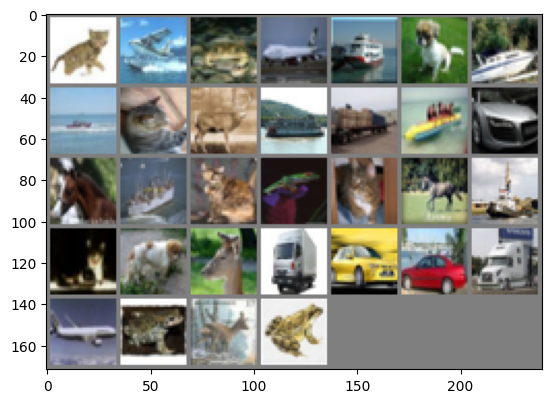

In [20]:
def imshow(imgs):
    imgs = imgs / 2 + 0.5  # unnormalize data
    npimgs = imgs.numpy()
    plt.imshow(np.transpose(npimgs, (1, 2, 0)))
    plt.show()


for _, (images, labels) in enumerate(train_loader):
    if _ < 1:
        img_grid = torchvision.utils.make_grid(images[0:33], nrow=7)
        imshow(img_grid)
        break

In [21]:
class ConvNet(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()
        # input shape 3 colors , 32 X 32
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(
            3, 32, 3
        )  # in_channels = 3 -> three colors , out_channels, kernel
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.linear1 = nn.Linear(64 * 4 * 4, 64)
        self.linear2 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        # N, 3, 32, 32
        x = F.relu(self.conv1(x))  # -> N, 32, 30, 30
        x = self.pool(x)  # -> N, 32, 15, 15
        x = F.relu(self.conv2(x))  # -> N, 64, 13, 13
        x = self.pool(x)  # -> N, 64, 6, 6
        x = F.relu(self.conv3(x))  # -> N, 64, 4, 4
        x = torch.flatten(x, 1)  # -> N, 1024
        x = F.relu(self.linear1(x))  # -> N, 64
        x = self.linear2(x)  # -> N, 10
        return x

In [22]:
model = ConvNet(num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(train_loader):

        # forward pass
        output = model.forward(images)
        # loss calculation
        loss: nn.CrossEntropyLoss = criterion(output, labels)

        # backward pass

        # calculate the gradient
        loss.backward()

        # update the weights
        optimizer.step()

        # zero the gradients after updating
        optimizer.zero_grad()

        running_loss += loss.item()

        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss = {loss}"
            )
    print(f"[{epoch + 1}] Average loss of Epoch {running_loss/ n_total_steps:.3f}")

Epoch [1/10], Step [100/1563], Loss = 2.0207676887512207
Epoch [1/10], Step [200/1563], Loss = 1.8389241695404053
Epoch [1/10], Step [300/1563], Loss = 2.050354480743408
Epoch [1/10], Step [400/1563], Loss = 1.6297123432159424
Epoch [1/10], Step [500/1563], Loss = 1.8261194229125977
Epoch [1/10], Step [600/1563], Loss = 1.3399492502212524
Epoch [1/10], Step [700/1563], Loss = 1.6144556999206543
Epoch [1/10], Step [800/1563], Loss = 1.2577946186065674
Epoch [1/10], Step [900/1563], Loss = 1.7517061233520508
Epoch [1/10], Step [1000/1563], Loss = 1.2811377048492432
Epoch [1/10], Step [1100/1563], Loss = 1.4483689069747925
Epoch [1/10], Step [1200/1563], Loss = 1.2208203077316284
Epoch [1/10], Step [1300/1563], Loss = 1.0894579887390137
Epoch [1/10], Step [1400/1563], Loss = 1.1513571739196777
Epoch [1/10], Step [1500/1563], Loss = 1.6264424324035645
[1] Average loss of Epoch 1.506
Epoch [2/10], Step [100/1563], Loss = 1.4214704036712646
Epoch [2/10], Step [200/1563], Loss = 1.24769961833

In [25]:
with torch.no_grad():
    no_correct = 0
    pred = []
    act = []
    n_samples = len(test_loader.dataset)
    for images, labels in test_loader:
        output = model.forward(images)
        # max returns (output_value, index)
        _, predicted = torch.max(output, 1)
        no_correct += (predicted == labels).sum().item()
        pred += predicted
        act += labels

print(f"Accuracy of model on {n_samples} test images: {(no_correct/n_samples)*100}")

Accuracy of model on 10000 test images: 72.94


In [39]:
import pandas as pd

df = pd.DataFrame(
    {"predicted": [_.item() for _ in pred], "Labels": [_.item() for _ in act]}
)